จาก ep ที่แล้ว ที่เราพัฒนาโปรแกรม [AI การแพทย์ วินิจฉัยภาวะปอดรั่ว Pneumothorax](https://www.bualabs.com/archives/2856/ai-diagnose-pneumothorax-read-chest-x-ray-radiograph-image-collapsed-lung-radiologist-triage-patient-classification-segment-medical-image-segmentation-ep-2/) ได้ผลดีพอสมควร ใน ep นี้เราจะปรับปรุงโมเดล ด้วยเทคนิคใหม่ ๆ เช่น [fastai2](https://www.bualabs.com/archives/4102/tutorial-fastai2-oxford-pets-dog-cat-37-class-machine-learning-deep-neural-networks-image-classification-ep-7/), [Data Echoing](https://www.bualabs.com/archives/4157/data-echoing-faster-neural-network-training-with-data-echoing-machine-learning-data-echoing-preprocessing-ep-6/), [Focal Loss](https://www.bualabs.com/archives/4227/what-is-focal-loss-loss-function-ep-4/), และ Ranger Optimizer แบบใหม่ ว่าจะได้ผลเป็นอย่างไร

# 0. Install

In [1]:
! nvidia-smi

Fri Jul 10 05:44:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

เราจะต้อง Install kaggle เพื่อ Download Dataset

In [3]:
# ## Colab
# ! pip install fastai2 pydicom kornia kaggle -q

In [4]:
# ## Colab

# !pip install torch-geometric \
#   torch-sparse==latest+cu101 \
#   torch-scatter==latest+cu101 \
#   torch-cluster==latest+cu101 \
#   -f https://pytorch-geometric.com/whl/torch-1.4.0.html 

# 1. Import Library

Import pydicom สำหรับเปิดไฟล์ภาพเอ็กซ์เรย์ DICOM นามสกุล dcm และ Libray อื่น ๆ ที่เราต้องการใช้

In [5]:
import math
import numpy as np
import pandas as pd

import os
import gc
import glob
import PIL 

import pydicom

from pathlib import Path
from matplotlib import cm
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from fastai2.metrics import *

from IPython.core.debugger import set_trace

import kornia

In [6]:
set_seed(1234)

# 2. เตรียม Path สำหรับดาวน์โหลดข้อมูล

กำหนด path ของ Config File และ Dataset ว่าจะอยู่ใน Google Drive ถ้าเราใช้ [Google Colab](https://www.bualabs.com/archives/1687/what-is-colab-open-jupyter-notebook-in-github-on-google-colab-create-open-in-colab-button-colab-ep-1/) หรือ อยู่ใน HOME ถ้าเราใช้ VM ธรรมดา และกำหนด Environment Variable ไปยังโฟลเดอร์ที่เก็บ kaggle.json

ในกรณีใช้ Colab ให้ Mount Google Drive เพื่อดึง Config File มาจาก Google Drive ส่วนตัวของเรา เมื่อเรารัน Cell ด้านล่างจะมีลิงค์ปรากฎขึ้นมาให้เรา Login กด Approve แล้ว Copy Authorization Code มาใส่ในช่องด้านล่าง แล้วกด Enter

ในเคสนี้เราจะดึงข้อมูลจากหลาย Dataset เนื่องจากเราจะใช้การเทรนแบบ Progressive Resizing ใช้รูปหลายขนาดในการเทรน 

In [7]:
dataset = 'siim-acr-pneumothorax-segmentation'
dataset2 = 'jesperdramsch/siim-acr-pneumothorax-segmentation-data'
# dataset3 = 'iafoss/siimacr-pneumothorax-segmentation-data-128'
# dataset4 = 'iafoss/siimacr-pneumothorax-segmentation-data-256'
# dataset5 = 'iafoss/siimacr-pneumothorax-segmentation-data-512'
dataset6 = 'iafoss/siimacr-pneumothorax-segmentation-data-1024'
dataset_test = 'ivanzhovannik/siim_stage2_png'

# Google Colab
config_path = Path('/content/drive')
learner_path = config_path/"My Drive"
data_path_base = Path('/content/datasets/')

data_path = data_path_base/dataset
data_path2 = data_path_base/dataset2
# data_path3 = data_path_base/dataset3
# data_path4 = data_path_base/dataset4
# data_path5 = data_path_base/dataset5
data_path6 = data_path_base/dataset6
data_path_test = data_path_base/dataset_test

from google.colab import drive
drive.mount(str(config_path))
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/My Drive/.kaggle"

# # VM
# config_path = Path(os.getenv("HOME"))
# learner_path = config_path
# data_path = config_path/"datasets"/dataset
# data_path2 = config_path/"datasets"/dataset2
# data_path3 = config_path/"datasets"/dataset3
# data_path4 = config_path/"datasets"/dataset4
# data_path5 = config_path/"datasets"/dataset5
# data_path6 = config_path/"datasets"/dataset6
# data_path_test = config_path/"datasets"/dataset_test

# data_path.mkdir(parents=True, exist_ok=True)
# os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/.kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Dataset

ในเคสนี้ เราจะ Download ข้อมูล Dataset ที่เกี่ยวข้องทั้งหมดมาเก็บไว้ แบ่งเป็นรูปฟิล์ม X-Ray ขนาดต่าง ๆ ข้อมูลต้นฉบับ ข้อมูล Test Set, etc.

Dataset เราจะดึงจาก Kaggle วิธี Download kaggle.json ให้ดูจาก ep ที่แล้ว

เมื่อได้ kaggle.json มาแล้ว ในกรณีใช้ Google Colab ให้นำมาใส่ไว้ในโฟลเดอร์ My Drive/.kaggle ใน Google Drive ของเรา เป็น My Drive/.kaggle/kaggle.json ถ้าใช้ VM ให้ใส่ใน HOME/.kaggle/

สั่งดาวน์โหลด Dataset จาก Kaggle พร้อมทั้ง unzip ไว้ใน data_path

In [8]:
# !kaggle competitions download -c {dataset} -p "{data_path}"
# !kaggle datasets download {dataset2} -p "{data_path2}" --unzip
# ## !kaggle datasets download {dataset3} -p "{data_path3}" --unzip
# ## !kaggle datasets download {dataset4} -p "{data_path4}" --unzip
# ## !kaggle datasets download {dataset5} -p "{data_path5}" --unzip
# !kaggle datasets download {dataset6} -p "{data_path6}" --unzip
# !kaggle datasets download {dataset_test} -p "{data_path_test}" --unzip

Unzip ไฟล์ที่ดาวน์โหลดจาก Kaggle Competition

In [9]:
# ! unzip -q {data_path}/siim-acr-pneumothorax-segmentation.zip -d {data_path}
# ! unzip -q {data_path}/stage_2_images.zip -d {data_path}/stage_2_images
# ! unzip -q {data_path}/stage_2_train.csv.zip -d {data_path}

Import ฟังก์ชันสำหรับแปลงข้อมูล Label ที่อยู่ในรูปแบบ Run-length encoding (RLE) to Mask ที่ให้มากับ Dataset

In [10]:
import sys
sys.path.insert(0, str(data_path))

from mask_functions import *

# 4. Data

## 4.1 DICOM Image

เปิดดูข้อมูลฟิล์มเอ็กซ์เรย์

In [11]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


วนลูปเปิดดูไฟล์ DICOM ที่จะมีทั้งรูป และ Metadata ข้อมูลประกอบ อยู่ในไฟล์เดียวกัน

Filename.........: /content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.32181.1517875158.910577/1.2.276.0.7230010.3.1.3.8323329.32181.1517875158.910576/1.2.276.0.7230010.3.1.4.8323329.32181.1517875158.910578.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: d84ad178-96b1-4ea4-baa0-e81c2882234b, 
Patient id..........: d84ad178-96b1-4ea4-baa0-e81c2882234b
Patient's Age.......: 54
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: AP
Image size.......: 1024 x 1024, 110854 bytes
Pixel spacing....: [0.168, 0.168]


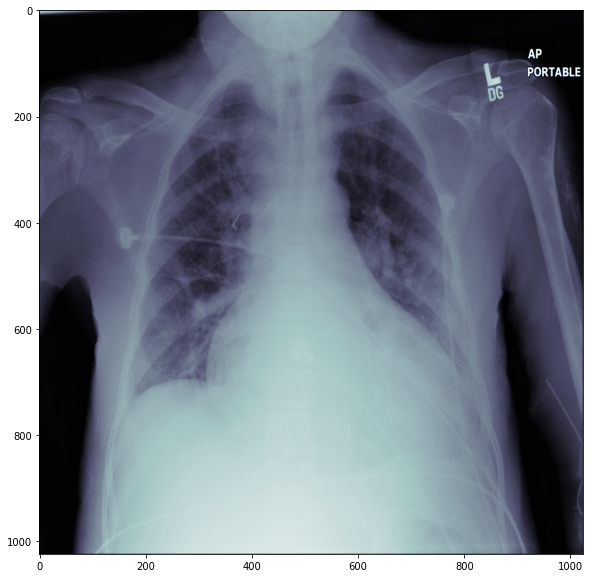

In [12]:
for file_path in glob.glob(str(data_path2/'pneumothorax/dicom-images-train/*/*/*.dcm')):
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    break # Comment this out to see all

ลองดูทีละหลาย ๆ ไฟล์

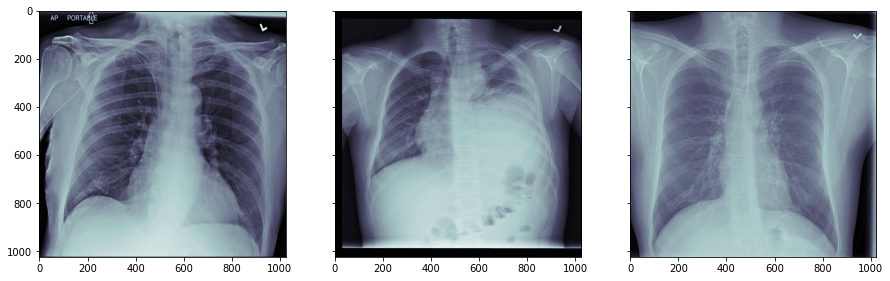

In [13]:
start = 33   # Starting index of images
num_img = 3 # Total number of images to show

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*5,5))
for q, file_path in enumerate(glob.glob(str(data_path2/'pneumothorax/dicom-images-train/*/*/*.dcm'))[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    #show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)


ดู Label ที่มาในรูปแบบ Run-length encoding (RLE) ดังที่เห็นใน Column EncodedPixels 

-1 หมายถึง ปอดปกติ

In [14]:
df = pd.read_csv(data_path2/'train-rle.csv', index_col=0)
df.head()

,EncodedPixels
ImageId,
1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1
1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1
1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002 22 1001 22 1000 23 1000 23 1000 23 999 24 999 23 1000 23 999 23 1000 22 1001 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1002 21 1002 20 1003 20 1002 21 1001 23 1000 23 999 24 999 24 999 23 999 24 999 24 998 26 996 27 995 28 995 28 994 30 993 30 993 30 993 30 993 31 992 31 992 31 992 31 992 32 990 33 990 33 990 33 991 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 993 30 993 30 993 30 993 30 994 29 994 29 994 30 993 30 994 29 994 30 993 30 993 31 993 31 992 31 992...
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 17 1006 19 1005 20 1003 21 1003 22 1001 23 1001 24 999 25 999 25 999 26 997 27 997 27 996 28 996 28 996 29 994 30 994 30 994 30 993 31 993 32 992 32 992 32 992 32 991 33 991 33 991 33 991 33 991 33 990 34 990 34 990 34 990 34 990 34 989 35 989 36 988 36 988 16 1 19 988 15 3 18 988 15 4 16 989 14 8 13 989 14 8 13 989 13 9 13 989 13 9 13 989 12 10 13 989 12 10 13 989 11 11 13 989 11 11 13 989 11 11 13 989 10 11 14 989 10 11 14 990 9 9 16 990 9 7 18 990 9 6 18 991 9 6 18 991 9 5 19 992 8 4 20 992 7 5 20 993 6 4 21 993 6 4 21 994 4 4 22 995 3 5 20 ...
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1015 8 1014 9 1014 9 1013 10 1013 10 1012 11 1011 12 1010 12 1011 12 1010 13 1009 14 1008 15 1008 15 1007 16 1007 16 1006 17 1006 17 1005 17 1005 18 1004 19 1004 18 1004 19 1004 19 1002 21 1001 22 1001 22 1000 23 1000 23 999 24 997 26 997 25 997 26 997 26 997 26 996 27 996 27 996 27 995 27 996 27 996 27 996 28 995 28 995 28 995 28 994 28 995 28 995 28 995 27 996 27 996 27 996 28 995 28 995 28 995 28 994 30 993 30 993 30 994 29 994 28 995 28 995 28 994 30 993 30 993 30 994 29 994 30 993 30 993 30 994 30 993 30 993 30 993 31 992 31 992 32 991 32 9...


In [15]:
df.shape

(11582, 1)

In [16]:
samples_per_cls = [len(df[df[' EncodedPixels']==' -1']), len(df[df[' EncodedPixels']!=' -1'])]
samples_per_cls

[8296, 3286]

## 4.2 Mask

ใช้ฟังก์ชันที่ได้มา แปลง RLE เป็น Mask ขนาด 1024 x 1024

In [17]:
mask = rle2mask(df.loc['1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709'][0].strip(), 1024, 1024).T
# a = mask.sum(axis=1)
# a = mask.sum(axis=0)
# a.argmax()

mask[105:115, 300:310]

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 255., 255., 255.],
       [  0.,   0.,   0.,   0.,   0., 255., 255., 255., 255., 255.],
       [  0.,   0.,   0., 255., 255., 255., 255., 255., 255., 255.],
       [  0., 255., 255., 255., 255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 255., 255., 255., 255.]])

เพื่อให้เห็นชัด ๆ เราจะแปลงเป็น Transparent ไว้สำหรับ Overlay กับภาพฟิล์ม X-Ray

In [18]:
mask_rgba = mask/255
mask_rgba = np.repeat(mask_rgba[:, :, np.newaxis], 4, axis=2)
mask_rgba[:, :, [1,2]] = 0
mask_rgba[:, :, 3] = mask_rgba[:, :, 3]*0.7

mask_rgba[105:115, 300:310, 0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

ลองแสดง Mask เป็นรูป

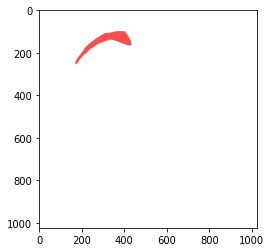

In [19]:
plt.imshow(mask_rgba)

## 4.3 DICOM Image and Mask

แสดงฟิล์ม X-Ray พร้อมระบายสี Pneumothorax ด้วย Mask สีแดง

In [20]:
start = 22   # Starting index of images
num_img = 3 # Total number of images to show

1.2.276.0.7230010.3.1.4.8323329.3800.1517875179.547338.dcm
Nothing to see
1.2.276.0.7230010.3.1.4.8323329.1136.1517875166.441388.dcm
See Marker
1.2.276.0.7230010.3.1.4.8323329.2267.1517875171.867949.dcm
Nothing to see


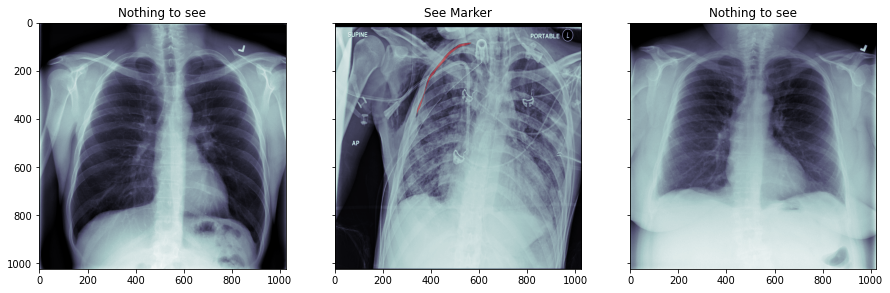

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*5,5))
for q, file_path in enumerate(glob.glob(str(data_path2/'pneumothorax/dicom-images-train/*/*/*.dcm'))[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    print(file_path.split('/')[-1])
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    fn = file_path.split('/')[-1][:-4]
    rle = df.loc[fn][0].strip()
    # print(rle)
    if rle != '-1':
        print('See Marker')
        mask = rle2mask(rle, 1024, 1024).T
        ax[q].set_title('See Marker')
#         # Normal Mask
#         ax[q].imshow(mask, alpha=0.3, cmap="rainbow")
        
        # Make alpha mask
        mask_rgba = mask/255
        mask_rgba = np.repeat(mask_rgba[:, :, np.newaxis], 4, axis=2)
        mask_rgba[:, :, [1,2]] = 0
        mask_rgba[:, :, 3] = mask_rgba[:, :, 3]*0.4

        ax[q].imshow(mask_rgba)
    else:
        print('Nothing to see')
        ax[q].set_title('Nothing to see')


# 5. Data Pipeline

เมื่อเราได้รูปด้านบนมาแล้ว เพื่อความสำดวก เราจะแปลงทั้งหมดเป็นไฟล์รูป .png เนื่องจาก Lossless แล้ว Resize เป็นขนาดต่าง ๆ ใส่ไว้ใน Folder ที่กำหนด ซึ่งมีคนทำไว้ให้เราแล้ว เราก็ไป Download มาใน Dataset 3, 4, 5, 6

กำหนด [Batch Size](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/), ขนาดของรูปที่จะเทรน และ Path ที่เก็บรูป

In [22]:
bs=64
e=2
SZ = 128
# path = data_path3
path = data_path6

ใช้ [Data Echoing](https://www.bualabs.com/archives/4157/data-echoing-faster-neural-network-training-with-data-echoing-machine-learning-data-echoing-preprocessing-ep-6/)

In [23]:
class EchoingTransform(ItemTransform):
    order = 2
    split_idx = 0
    def __init__(self, e): self.e = e
    def encodes(self, x):
        img, lbl = x
        if self.e > 1:
            img = img.repeat(self.e, 1, 1, 1)
            lbl = lbl.repeat(self.e, 1, 1)
        # print(img.shape)
        # print(lbl.shape)
        return img, lbl

เนื่องจาก mask อยู่ใน format ที่ไม่ได้เป็น 0, 1 แต่เป็นไล่สีขาวดำ 0, 64, 
128, 191, 255 เราจะต้องปรับให้เป็น class 0, 1

In [24]:
def label_func(fn): return str(fn).replace('train/train', 'masks')

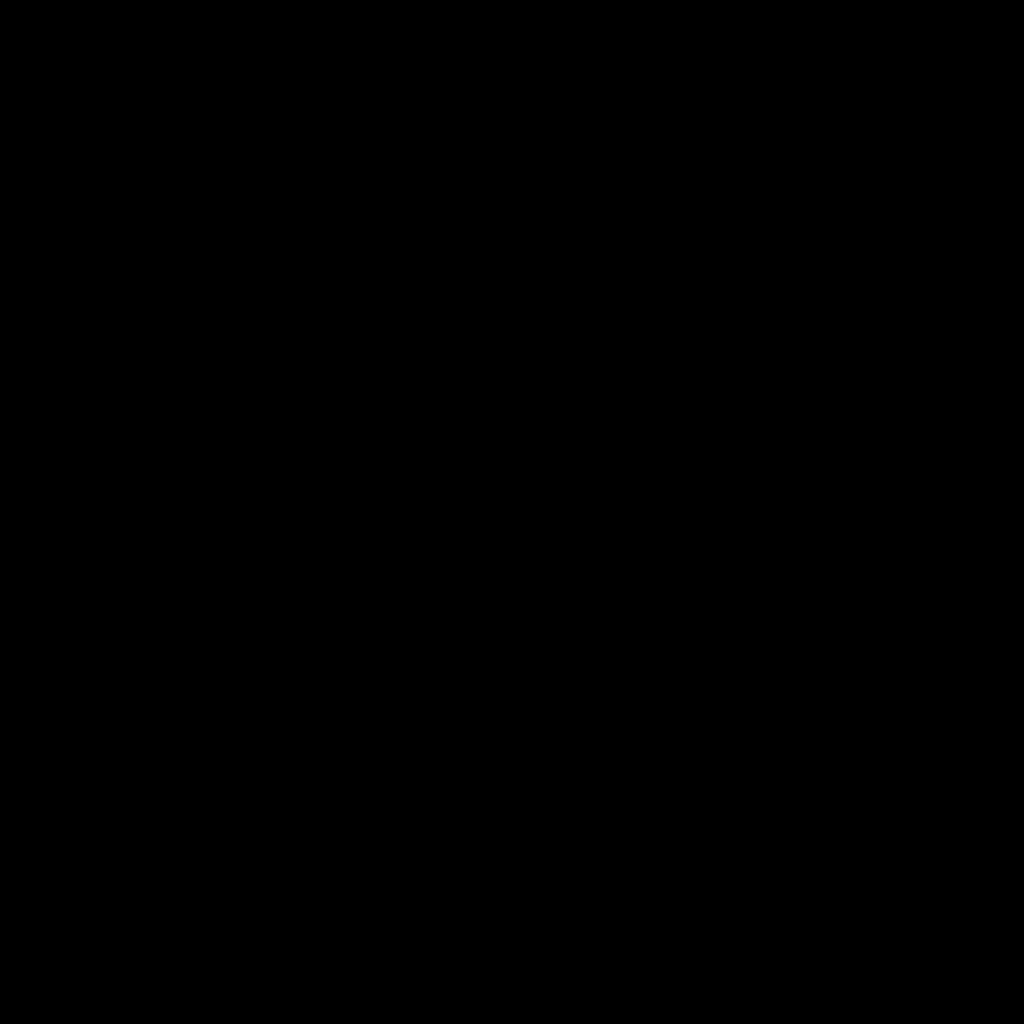

In [25]:
fn = get_image_files(path/'train')[111]
msk_fn = label_func(fn)
msk = PILMask.create(msk_fn)
msk

In [26]:
tensor(msk)[120:130, 420:430]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

In [27]:
def get_msk(fn):

  msk_fn = label_func(fn)
  msk = np.array(PILMask.create(msk_fn))
  
  msk[msk!=0] = 1
  return PILMask.create(msk)

ลองดู Mask หลังจากแปลงเรียบร้อยแล้ว

In [28]:
msk2 = get_msk(fn)
tensor(msk2)[120:130, 420:430]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

In [29]:
get_y = lambda o: get_msk(o)

ใช้ [DataBlock API](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) สร้าง [DataBunch](https://www.bualabs.com/archives/2318/databunch-learner-refactor-neural-network-training-loop-neural-network-ep-9/) เตรียมส่งให้ Model สำหรับเทรน โดย [Train/Validation Split](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) 80/20, แต่ละ Pixel เป็น Binary Classification 0/1 , ทำ [Data Augmentation](https://www.bualabs.com/archives/1170/what-is-data-augmentation-benefits-data-augmentaion-deep-learning-training-model-deep-neural-network-regularization-ep-1/) ทุกอย่างยกเว้น Flip Vertical แล้ว [Normalize](https://www.bualabs.com/archives/2100/what-is-normalization-feature-scaling-rescaling-normalization-standardization-feedforward-train-machine-learning-preprocessing-ep-2/) ด้วย imagenet_stats

In [30]:
codes = np.array(["Normal", "Pneumothorax"])

In [31]:
# aug_transforms??

In [32]:
def getDataBlock(size, e):
  return DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                  get_items = get_image_files,
                  get_y = get_y,
                  splitter=RandomSplitter(), 
                  item_tfms=RandomResizedCrop(size, min_scale=0.7, ratio=(1, 1)), 
                  # item_tfms=RandomResizedCrop(size), 
                  # batch_tfms = [EchoingTransform(e), *aug_transforms(flip_vert=True, max_rotate=180.0)])
                  batch_tfms = [EchoingTransform(e), *aug_transforms(do_flip=False)])
                  

In [33]:
data = getDataBlock(SZ, e)

In [34]:
# path = data_path6
# data.summary(path/'train')

In [35]:
dls = data.dataloaders(path/'train', bs=bs)

ได้ Traing Set และ Validation Set จำนวนดังนี้

In [36]:
len(dls.train_ds), len(dls.valid_ds)

(9638, 2409)

ดูข้อมูล 1 Batch 

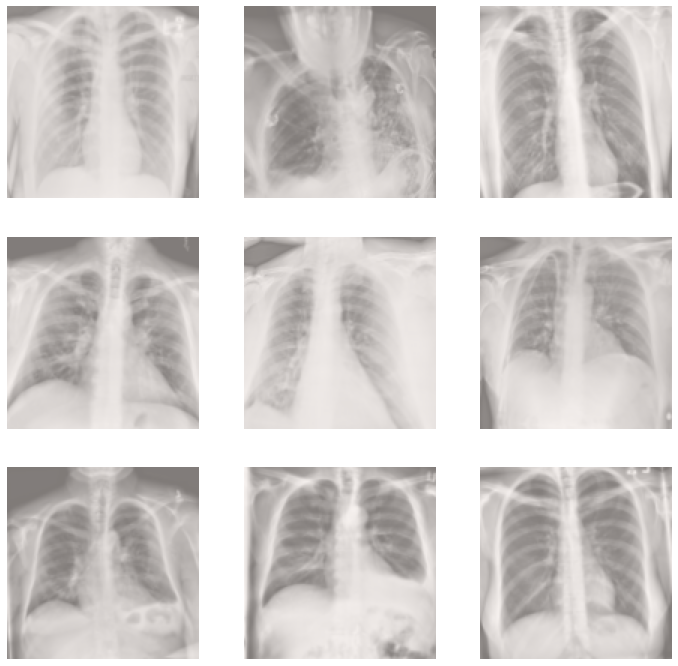

In [37]:
dls.show_batch(max_n=9, vmin=0, vmax=1, cmap='Reds', figsize=(12, 12))

# 6. Model

## 6.1 Dice Metric

Dice หรือ Sørensen–Dice coefficient เป็นการคำนวนสถิติที่ใช้วัดค่าความเหมือนกัน ของ 2 ข้อมูลตัวอย่าง ดังสมการด้านล่าง รายละเอียดเพิ่มเติมใน ep [Metrics / Confusion Matrix](https://www.bualabs.com/archives/1968/what-is-metrics-confusion-matrix-accuracy-precision-recall-f1-score-difference-metrics-ep-1/)

$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|} = \frac{2 TP}{2 TP + FP + FN} $$

## 6.2 U-Net and ResNet34

เราจะใช้ [Model Architecture](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/) เหมือน ep ที่แล้ว คือ U-Net และ ResNet34 แปลงโมเดลเป็นแบบ Mixed Precision Training และใช้ [Focal Loss](https://www.bualabs.com/archives/4227/what-is-focal-loss-loss-function-ep-4/) แทน Cross Entropy Loss ตามปกติ

In [38]:
class XFocalLoss(kornia.losses.FocalLoss):
    y_int = True
    def __init__(self, alpha: float, gamma: float = 2.0,
                 reduction: str = 'none') -> None:
        super(XFocalLoss, self).__init__(alpha, gamma, reduction)

    def forward(  # type: ignore
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:       

        # set_trace()
        # print(input.shape)
        # print(target.shape)
        return super().forward(input, target)      

    def decodes(self, x):    return x.argmax(dim=1)
    def activation(self, x): return F.softmax(x, dim=1)               

class XDiceLoss(kornia.losses.DiceLoss):
    y_int = True
    def __init__(self) -> None:
        super(XDiceLoss, self).__init__()

    def forward(  # type: ignore
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:       

        # set_trace()
        # print(input.shape)
        # print(target.shape)
        return super().forward(input, target)      

    def decodes(self, x):    return x.argmax(dim=1)
    def activation(self, x): return F.softmax(x, dim=1)                   

หาสัดส่วนของ Mask ต่อภาพทั้งหมด

In [39]:
b = dls.one_batch()
b[1].shape, b[1].float().mean()

(torch.Size([128, 128, 128]), TensorMask(0.0018, device='cuda:0'))

In [40]:
# loss_func = kornia.losses.FocalLoss(alpha= 0.5, gamma=2.0, reduction='mean')

# loss_func = LabelSmoothingCrossEntropy()

weights = torch.tensor([[0.9]*1 + [1.1]]).cuda()
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

# loss_func = CrossEntropyLossFlat(axis=1)

# loss_func = XFocalLoss(alpha=100.0, gamma=2.0, reduction='mean')

# loss_func = XDiceLoss()

# beta = 0.99
# no_of_classes = 2
# effective_num = 1.0 - np.power(beta, samples_per_cls)
# weights = (1.0 - beta) / np.array(effective_num)
# weights = weights / np.sum(weights) * no_of_classes
# weights = (1.0 - np.power(beta, samples_per_cls))
# weights = tensor(weights).cuda()
# loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

In [41]:
# unet_config??

In [42]:
metrics = [foreground_acc, Dice(), JaccardCoeff()]
# config = unet_config(self_attention=True, blur=True, act_cls=Mish)
config = unet_config(self_attention=True, blur=True)

opt_func = ranger

In [43]:
def getLearner(dls):
    return unet_learner(dls, resnet34, metrics=metrics, config=config,
                     loss_func=loss_func, 
                     pretrained=True,                      
                     path=learner_path, 
                     opt_func=opt_func, 
                     cbs=[ShowGraphCallback]).to_fp16()

In [44]:
learn = getLearner(dls)

In [45]:
# learn.summary()

# 7. Train

เราจะใช้ Progressive Resizing ข้อมูลตัวอย่างที่ป้อนให้กับโมเดล เหมือนใน [Image Segmentation ep.1](https://www.bualabs.com/archives/835/image-segmentation-semantic-segmentation-camvid-machine-learning-unet-deep-learning-image-segmentation-ep-1/) เริ่มต้น จาก 128, 256, 512 ไปจนถึง 1024 ที่เป็นขนาดต้นฉบับ 

## 7.1 Train 128

In [46]:
learn.freeze()

In [ ]:
# learn.lr_find()

epoch,train_loss,valid_loss,foreground_acc,dice,jaccard_coeff,time
0,0.044585,0.028084,0.000000,0.000000,0.000000,02:40


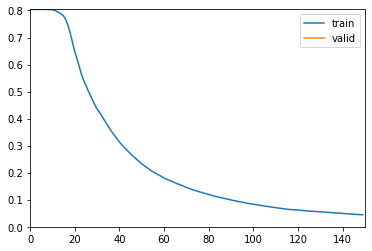

In [ ]:
learn.fit_one_cycle(1, lr_max=slice(3e-3), pct_start=0.8)

epoch,train_loss,valid_loss,foreground_acc,dice,jaccard_coeff,time
0,0.020634,0.025586,0.000000,0.000000,0.000000,02:31
1,0.019271,0.022810,0.000164,0.000281,0.000141,02:31
2,0.021357,0.023941,0.000000,0.000000,0.000000,02:30
3,0.020675,0.020861,0.003058,0.005767,0.002892,02:30
4,0.017949,0.025002,0.040348,0.072269,0.037489,02:30
5,0.018418,0.021959,0.000277,0.000574,0.000287,02:31
6,0.018458,0.020911,0.002944,0.005651,0.002834,02:31
7,0.016365,0.021082,0.017171,0.034397,0.017500,02:30
8,0.013789,0.019219,0.044590,0.087188,0.045581,02:30
9,0.012027,0.018867,0.215978,0.325591,0.194451,02:31


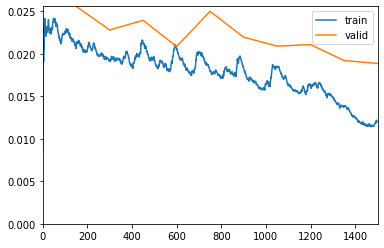

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(3e-3), pct_start=0.8)

In [ ]:
learn.save('03c-unet-resnet34-128-1')

In [ ]:
# learn.load('03c-unet-resnet34-128-1');

In [ ]:
learn.unfreeze()

In [ ]:
# learn.lr_find()

epoch,train_loss,valid_loss,foreground_acc,dice,jaccard_coeff,time
0,0.010895,0.019065,0.213517,0.323844,0.193206,02:38
1,0.011860,0.018916,0.224325,0.332195,0.199181,02:38
2,0.010818,0.019318,0.218941,0.329858,0.197503,02:38
3,0.010629,0.019237,0.230470,0.340028,0.204839,02:38


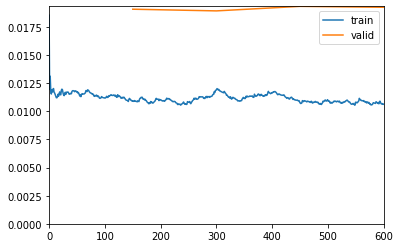

In [ ]:
# learn.fit_flat_cos(2, lr=slice(1e-6, 1e-4))
learn.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4), pct_start=0.7)

In [ ]:
learn.save('03c-unet-resnet34-128-2')

In [ ]:
# learn.show_results(max_n=9, vmin=0, vmax=1, cmap='Reds', figsize=(12, 12))

## 7.2 Increase Image size to 256

In [ ]:
learn = None
dls = None
gc.collect()
torch.cuda.empty_cache()

In [ ]:
bs = 32
e = 2
SZ = 224
# path = data_path4
path = data_path6

In [ ]:
data = getDataBlock(SZ, e)

In [ ]:
dls = data.dataloaders(path/'train', bs=bs)

In [ ]:
# dls.show_batch()

In [ ]:
learn = getLearner(dls)

In [ ]:
learn.load('03c-unet-resnet34-128-2')
learn.freeze()

In [ ]:
# learn.lr_find()

epoch,train_loss,valid_loss,foreground_acc,dice,jaccard_coeff,time
0,0.016443,0.017673,0.111144,0.189289,0.104538,06:47
1,0.014016,0.016343,0.163010,0.269420,0.155682,06:31
2,0.012873,0.017102,0.123473,0.218145,0.122426,06:31
3,0.013012,0.015269,0.228458,0.363247,0.221931,06:31
4,0.012309,0.014633,0.207032,0.345399,0.208751,06:31
5,0.012558,0.014571,0.214380,0.357494,0.217651,06:31
6,0.011960,0.019262,0.144419,0.259064,0.148808,06:31
7,0.011154,0.014333,0.203777,0.354185,0.215204,06:31
8,0.009577,0.014725,0.239814,0.386340,0.239419,06:30
9,0.007988,0.014651,0.280155,0.433371,0.276627,06:31


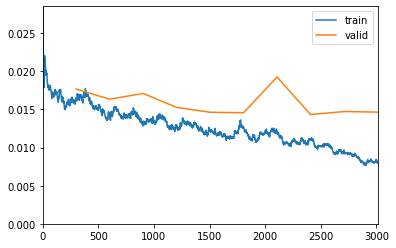

In [ ]:
# learn.fit_flat_cos(12, lr=slice(2e-4))
learn.fit_one_cycle(10, lr_max=slice(1e-3), pct_start=0.8)

In [ ]:
learn.save('03c-unet-resnet34-256-1')

In [ ]:
# learn.load('03c-unet-resnet34-256-1');

In [ ]:
learn.unfreeze()

In [ ]:
# learn.lr_find()

epoch,train_loss,valid_loss,foreground_acc,dice,jaccard_coeff,time
0,0.007775,0.014955,0.278367,0.431894,0.275424,06:51
1,0.007788,0.015024,0.277785,0.430650,0.274413,06:51
2,0.007806,0.015246,0.299591,0.448631,0.289184,06:51
3,0.007043,0.015351,0.284252,0.433381,0.276634,06:50


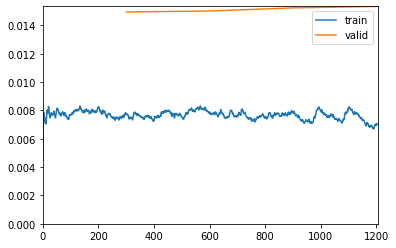

In [ ]:
# learn.fit_flat_cos(2, lr=slice(1e-6, 1e-4))
learn.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4), pct_start=0.7)

In [ ]:
learn.save('03c-unet-resnet34-256-2')

In [ ]:
# learn.load('03c-unet-resnet34-256-2');

In [ ]:
# learn.show_results(max_n=9, vmin=0, vmax=1, cmap='Reds', figsize=(12, 12))

## 7.3 Increase Image size to 384

In [ ]:
learn = None
dls = None
gc.collect()
torch.cuda.empty_cache()

In [ ]:
bs=14
e=2
SZ = 336
path = data_path6

In [ ]:
data = getDataBlock(SZ, e)

In [ ]:
dls = data.dataloaders(path/'train', bs=bs)

In [ ]:
# dls.show_batch()

In [ ]:
learn = getLearner(dls)

In [ ]:
learn.load('03c-unet-resnet34-256-2')
learn.freeze()

In [ ]:
# learn.lr_find()

epoch,train_loss,valid_loss,foreground_acc,dice,jaccard_coeff,time
0,0.010948,0.012334,nan,0.361185,0.220394,15:26
1,0.009633,0.012297,nan,0.358210,0.218183,15:07
2,0.010182,0.011604,nan,0.430692,0.274447,15:07
3,0.010793,0.010895,nan,0.455912,0.295263,15:07
4,0.010462,0.010788,nan,0.474027,0.310639,15:07
5,0.010111,0.013316,nan,0.353158,0.214445,15:07
6,0.008455,0.010888,nan,0.495132,0.329020,15:08
7,0.006826,0.011260,nan,0.484182,0.319420,15:07


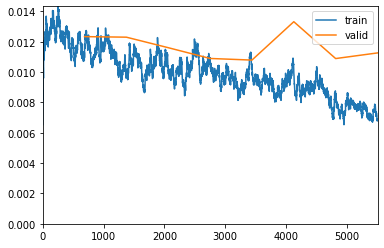

In [ ]:
# learn.fit_flat_cos(12, lr=slice(2e-4))
learn.fit_one_cycle(8, lr_max=slice(3e-4), pct_start=0.8)

In [ ]:
learn.save('03c-unet-resnet34-384-1')

In [ ]:
# learn.load('03c-unet-resnet34-384-1');

In [ ]:
learn.unfreeze()

In [ ]:
# learn.lr_find()

epoch,train_loss,valid_loss,foreground_acc,dice,jaccard_coeff,time
0,0.007099,0.012137,nan,0.455770,0.295144,15:52
1,0.006959,0.011314,nan,0.486950,0.321834,15:52


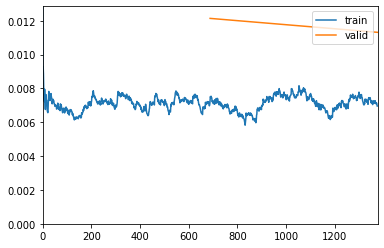

In [ ]:
# learn.fit_flat_cos(2, lr=slice(1e-6, 1e-4))
learn.fit_one_cycle(2, lr_max=slice(1e-6, 1e-4), pct_start=0.7)

In [ ]:
learn.save('03c-unet-resnet34-384-2')

In [ ]:
# learn.show_results(max_n=9, vmin=0, vmax=1, cmap='Reds', figsize=(12, 12))

## 7.4 Increase Image size to 512 

In [ ]:
learn = None
dls = None
gc.collect()
torch.cuda.empty_cache()

In [ ]:
bs=10
e=2
SZ = 448
path = data_path6

In [ ]:
data = getDataBlock(SZ, e)

In [ ]:
dls = data.dataloaders(path/'train', bs=bs)

In [ ]:
# dls.show_batch()

In [ ]:
learn = getLearner(dls)

In [ ]:
learn.load('03c-unet-resnet34-384-2')
learn.freeze()

In [ ]:
# learn.lr_find()

epoch,train_loss,valid_loss,foreground_acc,dice,jaccard_coeff,time
0,0.011122,0.010815,nan,0.486954,0.321837,28:42
1,0.008572,0.010651,nan,0.474468,0.311018,28:18
2,0.008741,0.010523,nan,0.484625,0.319805,28:18
3,0.009059,0.010093,nan,0.508494,0.340927,28:18
4,0.008075,0.010283,nan,0.509368,0.341712,28:18
5,0.008993,0.009848,nan,0.545868,0.375391,28:18
6,0.009157,0.010044,nan,0.532687,0.363036,28:18
7,0.008088,0.009996,nan,0.542606,0.372312,28:18


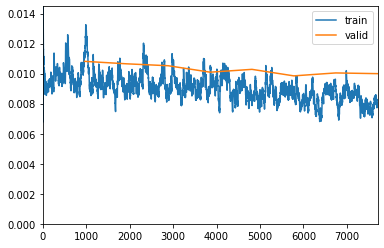

In [ ]:
# learn.fit_flat_cos(8, lr=slice(1e-4))
learn.fit_one_cycle(8, lr_max=slice(3e-5), pct_start=0.8)

In [ ]:
learn.save('03c-unet-resnet34-512-1')

In [ ]:
# learn.load('03c-unet-resnet34-512-1');

In [ ]:
learn.unfreeze()

In [ ]:
# learn.lr_find()

epoch,train_loss,valid_loss,foreground_acc,dice,jaccard_coeff,time
0,0.007171,0.009928,nan,0.548616,0.377995,29:31
1,0.007872,0.009909,nan,0.540121,0.369977,29:31


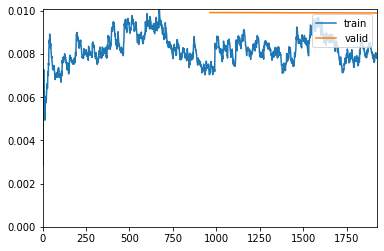

In [ ]:
# learn.fit_flat_cos(2, lr=slice(3e-7, 3e-5))
learn.fit_one_cycle(2, lr_max=slice(3e-7, 3e-5), pct_start=0.7)

In [ ]:
learn.save('03c-unet-resnet34-512-2')

In [ ]:
# learn.show_results(max_n=9, vmin=0, vmax=1, cmap='Reds', figsize=(12, 12))

## 7.5 Data Augmentation Annealing

ก่อน Infer เราจะเทรนด้วยข้อมูลที่ไม่ได้ทำ [Data Augmentation](https://www.bualabs.com/archives/1170/what-is-data-augmentation-benefits-data-augmentaion-deep-learning-training-model-deep-neural-network-regularization-ep-1/) ตบท้าย

In [170]:
learn = None
dls = None
gc.collect()
torch.cuda.empty_cache()

In [171]:
bs=20
e=1
SZ = 448
path = data_path6

In [172]:
# path.ls()

In [173]:
# Resize??

In [174]:
data = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                  get_items = get_image_files,
                  get_y = get_y,
                  splitter=RandomSplitter(0.01), 
                  item_tfms=Resize(SZ), 
                  # item_tfms=Resize(SZ, method='squish'), 
                #   item_tfms=RandomResizedCrop(SZ, min_scale=0.9, ratio=(1, 1)), 
                  # batch_tfms=[EchoingTransform(e)])
                  )                  

In [175]:
dls = data.dataloaders(path/'train', bs=bs)

In [176]:
# dls.show_batch()

In [177]:
learn = getLearner(dls)

In [178]:
learn.load('03c-unet-resnet34-512-2');

In [179]:
learn.unfreeze()

In [180]:
# learn.lr_find()

epoch,train_loss,valid_loss,foreground_acc,dice,jaccard_coeff,time
0,0.005646,0.007143,0.469848,0.676605,0.511264,17:05
1,0.005208,0.007065,0.519821,0.676665,0.511334,17:05
2,0.004253,0.007306,0.476833,0.683469,0.519144,17:06
3,0.003757,0.007648,0.471444,0.684446,0.520272,17:06


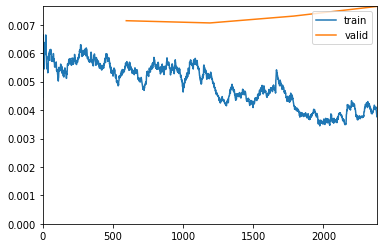

In [181]:
# learn.fit_flat_cos(4, lr=slice(1e-4))
learn.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4), pct_start=0.5)
# learn.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))

In [182]:
learn.save('03c-unet-resnet34-512-3')

In [183]:
# learn.load('03c-unet-resnet34-512-3');

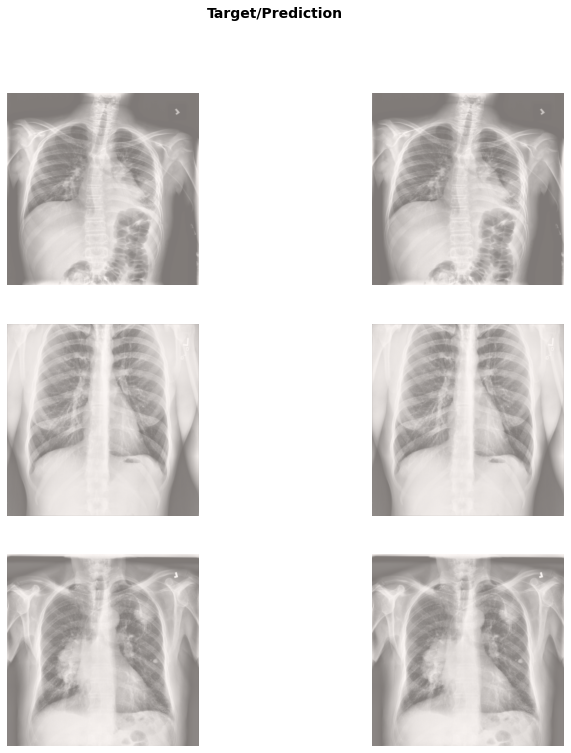

In [184]:
learn.show_results(max_n=9, vmin=0, vmax=1, cmap='Reds', figsize=(12, 12))

# 8. Make a Prediction

เทรนเสร็จแล้ว เราจะใช้โมเดลมาทำนายวินิจฉัย Pneumothorax หรือ ภาวะปอดรั่ว จากฟิล์ม X-Ray ใน Validation Set ที่เราแบ่งไว้ตอนแรก 20% ว่าจะตรงไหม

In [185]:
gc.collect()
torch.cuda.empty_cache()

In [186]:
# Predictions for the val set
preds, ys = learn.get_preds()
preds.shape, ys.shape

(torch.Size([120, 2, 448, 448]), torch.Size([120, 448, 448]))

In [187]:
preds = preds[:,1,...]
ys = ys.squeeze()

In [188]:
preds.shape, ys.shape

(torch.Size([120, 448, 448]), torch.Size([120, 448, 448]))

In [189]:
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

หา Threshold ให้ได้ ค่า Dice ที่ดีที่สุด

In [190]:
# Find optimal threshold
dices = []
thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean())
dices = np.array(dices)

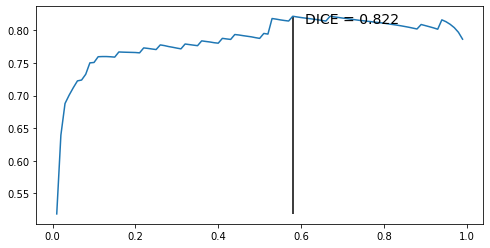

In [191]:
best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

ดูผลลัพธ์ในการวิจิฉัยภาวะปอดรั่ว (Pneumothorax) จะเห็นเป็น Image Segmentation เป็นสีเหลืองเขียว บริเวณปอดที่มีภาวะปอดรั่ว (Pneumothorax) เทียบกับ Label จากข้อมูลตัวอย่างใน Dataset

จะเห็นว่าโมเดลของเราวินิจฉัยได้อย่างแม่นยำ 

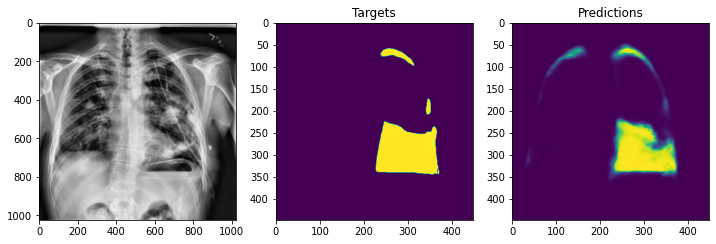

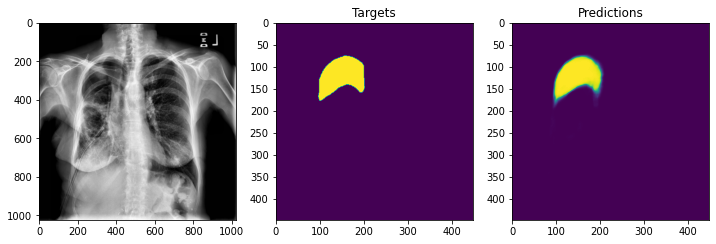

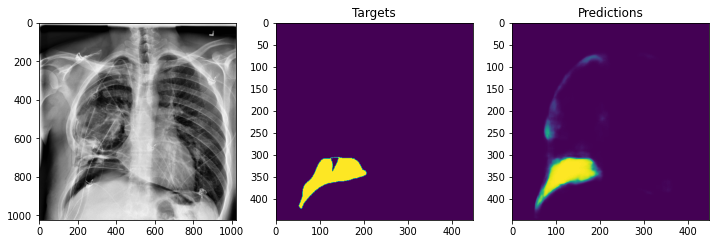

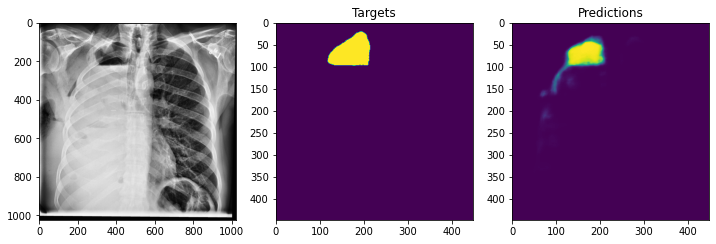

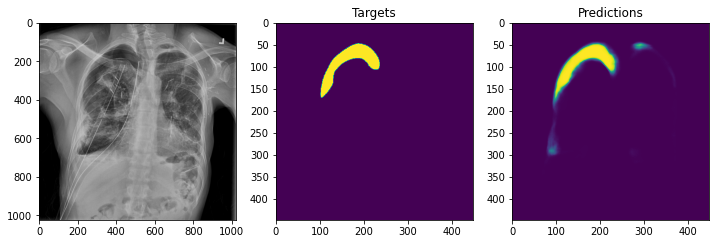

In [192]:
# Plot some samples
rows = 5
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(dls.valid_ds[idx][0])
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

# 10. Submit Predictions to Kaggle

ส่งผลการวินิจฉัยฟิล์ม X-Ray ใน Test Set ไปให้ Kaggle ตรวจ

In [193]:
tst_fns = get_image_files(data_path_test)

In [194]:
dl = learn.dls.test_dl(tst_fns)

In [195]:
# dl.show_batch()

In [196]:
b = dl.one_batch()
b[0][1]

tensor([[[ 2.1804,  2.1462,  2.0777,  ...,  1.5125,  1.5468,  1.2385],
         [ 2.1119,  2.0777,  2.0434,  ...,  1.4954,  1.5297,  1.2214],
         [ 2.0605,  2.0263,  1.9749,  ...,  1.4954,  1.5297,  1.2214],
         ...,
         [-1.8439, -1.8439, -1.8439,  ..., -1.3644, -0.9192, -0.7308],
         [-1.8439, -1.8439, -1.8439,  ..., -1.3473, -0.9192, -0.7308],
         [-1.8439, -1.8439, -1.8439,  ..., -1.3473, -0.9020, -0.7137]],

        [[ 2.3585,  2.3235,  2.2535,  ...,  1.6758,  1.7108,  1.3957],
         [ 2.2885,  2.2535,  2.2185,  ...,  1.6583,  1.6933,  1.3782],
         [ 2.2360,  2.2010,  2.1485,  ...,  1.6583,  1.6933,  1.3782],
         ...,
         [-1.7556, -1.7556, -1.7556,  ..., -1.2654, -0.8102, -0.6176],
         [-1.7556, -1.7556, -1.7556,  ..., -1.2479, -0.8102, -0.6176],
         [-1.7556, -1.7556, -1.7556,  ..., -1.2479, -0.7927, -0.6001]],

        [[ 2.5703,  2.5354,  2.4657,  ...,  1.8905,  1.9254,  1.6117],
         [ 2.5006,  2.4657,  2.4309,  ...,  1

In [197]:
gc.collect()
torch.cuda.empty_cache()

In [198]:
# Predictions for test set
preds, _ = learn.get_preds(dl=dl)
preds = (preds[:,1,...]>best_thr).long().numpy()
# print(preds.sum())

In [199]:
preds.shape

(3205, 448, 448)

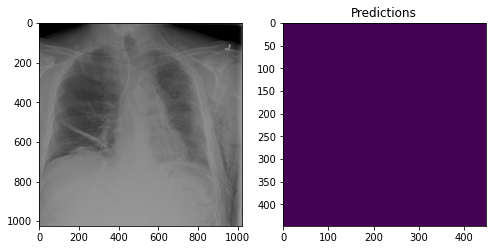

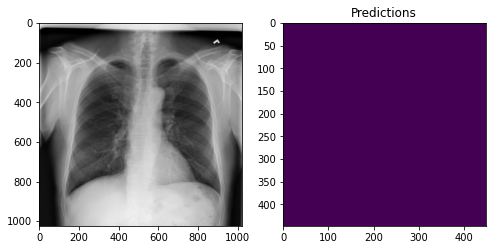

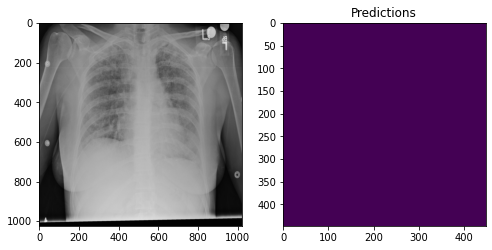

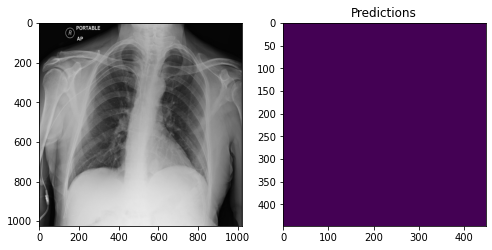

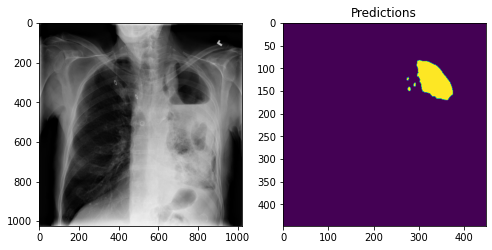

In [200]:
# Plot some samples
rows = 5
plot_idx = np.arange(rows)
for idx in plot_idx:
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4))
    ax0.imshow(dl.dataset[idx][0])
    ax1.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Predictions')

In [201]:
# preds[1, 90:110, 110:130]

In [202]:
# p = preds[1]
# tst_im = PIL.Image.fromarray((p.T*255).astype(np.uint8)).resize((1024,1024), resample=PIL.Image.NEAREST)
# tst_im = np.asarray(tst_im)
# tst_im[240:260, 200:220]

In [203]:
# tst_msk = mask2rle(tst_im, 1024, 1024)
# tst_msk

แปลงจากรูป เป็น RLE เหมือนเดิม

In [204]:
# # Generate rle encodings (images are first converted to the original size)
def resize_mask2rle(p):
    im = PIL.Image.fromarray((p.T*255).astype(np.uint8)).resize((1024,1024), resample=PIL.Image.NEAREST)
    im = np.asarray(im)
    return mask2rle(im, 1024, 1024)

In [205]:
### Serial Version
rles = []
for p in progress_bar(preds):
    rles.append(resize_mask2rle(p))

# ### Parallel Version
# import multiprocessing as mp
# # mp.cpu_count()
# p=mp.Pool(4)                    
# rles = p.map(resize_mask2rle, preds)

แปลงเป็น DataFrame ก่อน Save เป็นไฟล์ CSV

In [206]:
ids = [o.stem for o in dl.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

,ImageId,EncodedPixels
0,ID_fa1f5a727,-1
1,ID_08fdfe57b,-1
2,ID_4eb978211,-1
3,ID_9cdb3f251,-1
4,ID_240440107,639253 2 2 7 1013 2 2 7 1013 11 1013 11 1013 11 1010 16 39 7 962 16 39 7 960 16 37 16 955 16 37 16 960 6 39 21 958 6 39 21 1003 21 1003 21 1003 21 1003 21 1003 21 1006 18 1006 18 1010 9 1015 9 1015 9 14307 9 1015 9 1015 9 1010 16 1008 16 1006 18 1006 18 1006 18 1006 18 1006 16 1008 16 1008 16 5008 11 1013 11 1013 11 999 30 32 2 2 12 946 30 32 2 2 12 944 39 25 16 944 39 25 16 944 59 2 19 944 59 2 19 941 85 939 85 939 85 939 90 934 90 934 94 14 2 914 94 14 2 914 99 2 11 912 99 2 11 912 99 2 11 912 115 909 115 912 116 908 116 908 132 892 132 892 144 880 144 880 144 882 149 875 149 875 153 871...


In [207]:
sub_df.shape

(3205, 2)

In [208]:
sub_df.to_csv('submission.csv', index=False)

In [209]:
! kaggle competitions submit siim-acr-pneumothorax-segmentation -f {'submission.csv'} -m "My submission Weighted CE min_scale0.7 Ranger 30"

100% 589k/589k [00:00<00:00, 2.29MB/s]
Successfully submitted to SIIM-ACR Pneumothorax Segmentation

In [210]:
# Auto Play Audio file
import IPython.display as ipd
ipd.Audio(url="http://www.w3schools.com/html/horse.ogg",
                              autoplay=True) 



| Name           | Submitted    | Wait time | Execution time | Score   |
|----------------|--------------|-----------|----------------|---------|
| submission.csv | a day ago    | 0 seconds | 1 seconds      | 0.9060  |


เราได้ Public Leaderboard 0.9060, Private Leaderboard 0.8104 อยู่ที่อันดับ 280 จาก 1475 ดังตารางด้านล่าง = Top 20%

| #   	| Team Name      	| Score  	| Last 	|
|-----	|----------------	|--------	|------	|
| 278 	| UWRad          	| 0.8113 	| 2mo  	|
| 279 	| Mitul          	| 0.8105 	| 2mo  	|
| 280 	| diCELLa        	| 0.8096 	| 2mo  	|
| 281 	| lucaskg        	| 0.8094 	| 2mo  	|
| 282 	| Insaf Ashrapov 	| 0.8091 	| 2mo  	|



Top 10 ใน Private Leaderboard คือ อันดับที่ 147 จาก 1475 ทีม Dice = 0.8320 

# สรุป

* เราได้สร้าง AI วิจิฉัยภาวะปอดรั่ว (Pneumothorax) ที่ทำงานได้อย่าง อย่างแม่นยำพอสมควร ด้วยการเทรนโมเดล ด้วย GPU ไม่ถึง 24 ชั่วโมง
* แทนที่จะใช้รูป PNG จาก Dataset ที่คนทำไว้ให้แล้ว เราสามารถแปลงไฟล์เองจากไฟล์ DICOM ต้นฉบับ เลือก Window ข้อมูลที่เราต้องการ เพื่อปรับปรุ่งความแม่นยำให้มากขึ้น
* เราสามารถเพิ่มความซับซ้อนของโมเดล, รูปขนาดใหญ่ขึ้น, Loss Function, Multi-Head และใช้ GPU รุ่นใหม่ขึ้นในการเทรน ให้ได้ผลลัพธ์ที่แม่นยำมากขึ้น รวดเร็วขึ้นไปอีก
* เราสามารถประยุกต์ใช้โมเดลนี้ กับโรคที่คล้าย ๆ กันอีกหลายโรค ที่ต้องวินิจฉัยโดย Radiologist (แพทย์รังสีวิทยา) อ่านฟิล์ม X-Ray

# Credit

* https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/
* https://siim.org/
* https://www.bualabs.com/archives/2856/ai-diagnose-pneumothorax-read-chest-x-ray-radiograph-image-collapsed-lung-radiologist-triage-patient-classification-segment-medical-image-segmentation-ep-2/
* https://www.bualabs.com/archives/835/image-segmentation-semantic-segmentation-camvid-machine-learning-unet-deep-learning-image-segmentation-ep-1/
* https://en.wikipedia.org/wiki/Pneumothorax
* https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data/
* https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
* https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data
* https://www.kaggle.com/iafoss/hypercolumns-pneumothorax-fastai-0-831-lb
* https://www.kaggle.com/iafoss/siimacr-pneumothorax-segmentation-data-128
* https://www.kaggle.com/iafoss/siimacr-pneumothorax-segmentation-data-256
* https://www.kaggle.com/iafoss/siimacr-pneumothorax-segmentation-data-512
* https://www.kaggle.com/iafoss/siimacr-pneumothorax-segmentation-data-1024
* https://www.kaggle.com/mnpinto/pneumothorax-fastai-u-net
* https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
* https://www.kaggle.com/meaninglesslives/unet-with-efficientnet-encoder-in-keras
* https://pydicom.github.io/pydicom/stable/getting_started.html
* https://docs.python.org/2/library/glob.html
* https://arxiv.org/abs/1505.04597
* https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
* https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/04_Segmentation.ipynb
* https://kornia.readthedocs.io/en/latest/_modules/kornia/losses/focal.html
* https://arxiv.org/abs/1901.05555